In [1]:
from preprocessing import Preprocessor
from training import Trainer
from metrics import Metrics
import torch.nn as nn
import torch.optim as optim
from models.autoencoders import Simple_AE, VAE
from configuration import Hyperparameters as HP
import torch
import json
import math

years = [str(y) for y in range(2006, 2015)]

classes = ["detritus", "Leptocylindrus", "Chaetoceros", "Rhizosolenia", "Guinardia_delicatula", "Cerataulina", "Cylindrotheca",
    "Skeletonema", "Dactyliosolen", "Thalassiosira", "Dinobryon", "Corethron", "Thalassionema", "Ditylum", "pennate", "Prorocentrum",
    "Pseudonitzschia", "Tintinnid", "Guinardia_striata", "Phaeocystis"]

all_classes = ["mix", "detritus", "Leptocylindrus", "mix_elongated", "Chaetoceros", "dino30", "Rhizosolenia", "Guinardia_delicatula", 
"Cerataulina", "Cylindrotheca", "Skeletonema", "Ciliate_mix", "Dactyliosolen", "Thalassiosira", "bad", "Dinobryon", "Corethron", 
"DactFragCerataul", "Thalassionema", "Ditylum", "pennate", "Prorocentrum", "Pseudonitzschia", "Mesodinium_sp", "G_delicatula_parasite", 
"Tintinnid", "Guinardia_striata", "Phaeocystis", "Dictyocha", "Pleurosigma", "Eucampia", "Thalassiosira_dirty", 
"Asterionellopsis", "flagellate_sp3", "Laboea_strobila", "Chaetoceros_didymus_flagellate", "Heterocapsa_triquetra", "Guinardia_flaccida", 
"Chaetoceros_pennate", "Ceratium", "Euglena", "Coscinodiscus", "Strombidium_morphotype1", "Paralia", "Gyrodinium", "Ephemera", "Pyramimonas_longicauda", 
"Proterythropsis_sp", "Gonyaulax", "kiteflagellates", "Chrysochromulina", "Chaetoceros_didymus", "bead", "Katodinium_or_Torodinium", "Leptocylindrus_mediterraneus", 
"spore", "Tontonia_gracillima", "Delphineis", "Dinophysis", "Strombidium_morphotype2", "Licmophora", "Lauderia", "clusterflagellate", "Strobilidium_morphotype1", 
"Leegaardiella_ovalis", "pennate_morphotype1", "amoeba", "Strombidium_inclinatum", "Pseudochattonella_farcimen", "Amphidinium_sp", "dino_large1", 
"Strombidium_wulffi", "Chaetoceros_flagellate", "Strombidium_oculatum", "Cerataulina_flagellate", "Emiliania_huxleyi", "Pleuronema_sp", "Strombidium_conicum",
 "Odontella", "Protoperidinium", "zooplankton", "Stephanopyxis", "Tontonia_appendiculariformis", "Strombidium_capitatum", "Bidulphia", "Euplotes_sp", 
 "Parvicorbicula_socialis", "bubble", "Hemiaulus", "Didinium_sp", "pollen", "Tiarina_fusus", "Bacillaria", "Cochlodinium", "Akashiwo", "Karenia"]

classes_30 = ["Asterionellopsis", "bad", "Chaetoceros", "Chaetoceros_flagellate", "Ciliate_mix", "Corethron", "Cylindrotheca", "Dictyocha","dino30", "detritus",
	"Dinobryon", "Ditylum", "Eucampia", "flagellate_sp3", "Guinardia_delicatula", "Guinardia_flaccida", "Guinardia_striata", "Heterocapsa_triquetra", "Laboea_strobila", "Leptocylindrus",
	"pennate", "Phaeocystis", "Pleurosigma", "Prorocentrum", "Pseudonitzschia", "Skeletonema", "Thalassionema", "Thalassiosira", "Thalassiosira_dirty", "Tintinnid"]

classes_vae = ["Chaetoceros_flagellate"]

print(len(classes_30))


30


In [ ]:
"""  SIMPLE AUTOENCODER  """
#pp = Preprocessor(years, include_classes=classes, train_eg_per_class=HP.number_of_images_per_class)
#pp = Preprocessor(years, include_classes=all_classes, train_eg_per_class=HP.number_of_images_per_class, thresholding=HP.thresholding)
pp = Preprocessor(years, include_classes=classes_30, strategy = HP.pp_strategy, train_eg_per_class=HP.number_of_images_per_class, maxN = HP.maxN, minimum = HP.minimum, transformations = HP.transformations)


pp.create_datasets([0.6,0.2,0.2])

trainLoader = pp.get_loaders('train', HP.batch_size)
validLoader = pp.get_loaders('validation', HP.batch_size)
testLoader = pp.get_loaders('test', HP.batch_size)


trainer = Trainer(HP_version = HP.version, epochs = HP.number_of_epochs, loss_fn = HP.loss_function, 
	optimizer = HP.optimizer, scheduler = HP.scheduler, lr = HP.learning_rate, momentum = HP.momentum, useCuda=True, autoencoder=True)

model = Simple_AE()

trainAcc = []
validAcc = [] 
epochs = 0 


path_to_statedict = "models/Simple_AE_3.0-10.1.pth"

if ".tar" in path_to_statedict:
    model = trainer.load_partial_model(model, path_to_statedict)
else:
    model = trainer.load_full_model(model, path_to_statedict)

device = torch.device("cuda:1")
model.to(device)
    

In [ ]:
import random
import matplotlib.pyplot as plt

for data in testLoader:
    inputs, label = data['image'].to(device).float(), data['label']
    rand = random.randint(0,127)
    img = inputs[rand]
    lbl = label[rand]
    img = img.reshape((1,1,128,264))
    out = model(img)
    out_latent = model.get_latent(img)
    break

np_out = out[0].repeat((3,1,1)).permute(1,2,0).detach().cpu().numpy()
np_img = img[0].repeat((3,1,1)).permute(1,2,0).detach().cpu().numpy()

print(np_img.shape)
print(lbl)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np_img, cmap="gray")
ax2.imshow(np_out)


In [ ]:
x = trainer.test_autoencoder(model, testLoader)
torch.mean(x[0])

149
149
(64, 128, 3)
Chaetoceros_flagellate


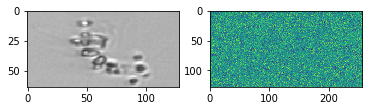

In [7]:
""" Variational Autoencoder  """

#pp = Preprocessor(years, include_classes=classes, train_eg_per_class=HP.number_of_images_per_class)
#pp = Preprocessor(years, include_classes=all_classes, train_eg_per_class=HP.number_of_images_per_class, thresholding=HP.thresholding)
pp = Preprocessor(years, include_classes=classes_vae, strategy = HP.pp_strategy, train_eg_per_class=HP.number_of_images_per_class, maxN = HP.maxN, minimum = HP.minimum, transformations = HP.transformations)


pp.create_datasets([0.8,0.1,0.1])

trainLoader = pp.get_loaders('train', HP.batch_size)
validLoader = pp.get_loaders('validation', HP.batch_size)
testLoader = pp.get_loaders('test', HP.batch_size)


trainer = Trainer(HP_version = HP.version, epochs = HP.number_of_epochs, loss_fn = HP.loss_function, 
	optimizer = HP.optimizer, scheduler = HP.scheduler, lr = HP.learning_rate, momentum = HP.momentum, useCuda=True, autoencoder=True)

model = VAE()


path_to_statedict = "models/VAE_2.0-12.1.pth"

if ".tar" in path_to_statedict:
    model = trainer.load_partial_model(model, path_to_statedict)
else:
    model = trainer.load_full_model(model, path_to_statedict)

device = torch.device("cpu")
model.to(device)

sample = model.get_sample()

sample = sample.view(128, 256).data


import random
import matplotlib.pyplot as plt

for data in testLoader:
    inputs, label = data['image'].to(device).float(), data['label']
    rand = random.randint(0,14)
    img = inputs[rand]
    lbl = label[rand]
    img = img.reshape((1,1,64,128))
    break

np_img = img[0].repeat((3,1,1)).permute(1,2,0).detach().cpu().numpy()

print(np_img.shape)
print(lbl)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np_img, cmap="gray")
ax2.imshow(sample)

3
